In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import EfficientNetV2L
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17579241562991872671
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6940786688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2219773827749761835
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
print(tf.__version__)

2.8.0


In [6]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
train_path="fer_ckplus_kdef_split/train"
test_path="fer_ckplus_kdef_split/test"
val_path="fer_ckplus_kdef_split/val"


In [8]:
(height, width, channels) = (80, 48, 3)

x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_test.append(img_arr)
        
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_val.append(img_arr)



In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0





In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (height, width),
                                                 batch_size = 32,
                                                 class_mode = 'sparse',
                                                 color_mode="grayscale"
                                                )
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (height, width),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                            color_mode="grayscale")
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (height, width),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                            color_mode="grayscale")

Found 26177 images belonging to 7 classes.
Found 3278 images belonging to 7 classes.
Found 3269 images belonging to 7 classes.


In [13]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [14]:
#training_set.class_indices
train_y.shape,test_y.shape,val_y.shape


((26177,), (3278,), (3269,))

In [15]:
IMAGE_SIZE = [48,80]

In [16]:
DenseNet121 = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


29097984/29084464 [==============================] - 34s 1us/step


In [18]:
for layer in DenseNet121.layers:
    layer.trainable = False

In [19]:
x = Flatten()(DenseNet121.output)


In [20]:
prediction = Dense(7, activation='softmax')(x)

model = Model(inputs=DenseNet121.input, outputs= prediction)

In [21]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 80, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 86, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 24, 40, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 24, 40, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

 conv2_block4_1_bn (BatchNormal  (None, 12, 20, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 12, 20, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 12, 20, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 12, 20, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
          

                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 6, 10, 128)  512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 6, 10, 128)  0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 6, 10, 32)    36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_concat (Concatena  (None, 6, 10, 192)  0           ['conv3_block1_concat[0][0]',    
 te)      

 conv3_block6_2_conv (Conv2D)   (None, 6, 10, 32)    36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 6, 10, 320)  0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 6, 10, 320)  1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 6, 10, 320)  0           ['conv3_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block11_0_relu (Activati  (None, 6, 10, 448)  0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 6, 10, 128)   57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 6, 10, 128)  512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_1_relu (Activati  (None, 6, 10, 128)  0           ['conv3_block11_1_bn[0][0]']     
 on)      

 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 3, 5, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 3, 5, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 3, 5, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block7_1_bn (BatchNormal  (None, 3, 5, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 3, 5, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 3, 5, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 3, 5, 480)   0           ['conv4_block6_concat[0][0]',    
 te)                                                              'conv4_block7_2_conv[0][0]']    
          

                                                                                                  
 conv4_block11_concat (Concaten  (None, 3, 5, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 3, 5, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 3, 5, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block16_0_relu (Activati  (None, 3, 5, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 3, 5, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 3, 5, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 3, 5, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block20_1_relu (Activati  (None, 3, 5, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 3, 5, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 3, 5, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_block21_0_bn (BatchNorma  (None, 3, 5, 896)   3584        ['conv4_block20_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 3, 5, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 3, 5, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 3, 5, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 1, 2, 512)    0           ['pool4_conv[0][0]']             
                                                                                                  
 conv5_blo

 conv5_block4_concat (Concatena  (None, 1, 2, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 1, 2, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 1, 2, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block5_1_conv (Conv2D)   (None, 1, 2, 128)    81920       ['conv5_block5_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 1, 2, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 1, 2, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 1, 2, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block13_1_relu (Activati  (None, 1, 2, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 1, 2, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 1, 2, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 1, 2, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)                                                                                        
          

In [22]:
model.compile(
  tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

In [24]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=50,
  callbacks=[early_stop],
  batch_size=64,shuffle=True)

Epoch 1/50
410/410 [==============================] - 25s 45ms/step - loss: 1.6478 - accuracy: 0.3870 - val_loss: 1.5791 - val_accuracy: 0.4026
Epoch 2/50
410/410 [==============================] - 16s 38ms/step - loss: 1.4840 - accuracy: 0.4425 - val_loss: 1.4880 - val_accuracy: 0.4445
Epoch 3/50
410/410 [==============================] - 16s 39ms/step - loss: 1.4352 - accuracy: 0.4671 - val_loss: 1.5558 - val_accuracy: 0.4209
Epoch 4/50
410/410 [==============================] - 16s 40ms/step - loss: 1.4135 - accuracy: 0.4734 - val_loss: 1.4761 - val_accuracy: 0.4521
Epoch 5/50
410/410 [==============================] - 16s 40ms/step - loss: 1.3937 - accuracy: 0.4850 - val_loss: 1.4752 - val_accuracy: 0.4582
Epoch 6/50
410/410 [==============================] - 17s 40ms/step - loss: 1.3863 - accuracy: 0.4893 - val_loss: 1.4763 - val_accuracy: 0.4567
Epoch 7/50
410/410 [==============================] - 17s 40ms/step - loss: 1.3688 - accuracy: 0.4939 - val_loss: 1.5121 - val_accuracy:

In [25]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [26]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [27]:
print(classification_report(y_pred,test_y,zero_division=0))


              precision    recall  f1-score   support

           0       0.62      0.26      0.37      1119
           1       0.28      0.73      0.40        30
           2       0.29      0.31      0.30       325
           3       0.61      0.62      0.62       905
           4       0.40      0.40      0.40       509
           5       0.09      0.54      0.16        95
           6       0.44      0.64      0.52       295

    accuracy                           0.43      3278
   macro avg       0.39      0.50      0.40      3278
weighted avg       0.52      0.43      0.44      3278



In [28]:
confusion_matrix_=confusion_matrix(y_pred,test_y)


In [29]:
confusion_matrix_

array([[295,  47, 107, 195, 158, 240,  77],
       [  1,  22,   0,   0,   2,   4,   1],
       [ 37,   4, 100,  43,  35,  41,  65],
       [ 70,   4,  37, 557,  79, 123,  35],
       [ 43,   1,  54,  79, 203,  74,  55],
       [ 13,   0,  11,   8,   9,  51,   3],
       [ 14,   2,  37,  24,  22,   8, 188]], dtype=int64)

In [30]:
import seaborn as sb
from matplotlib.colors import LogNorm, PowerNorm


Confusion Matrix


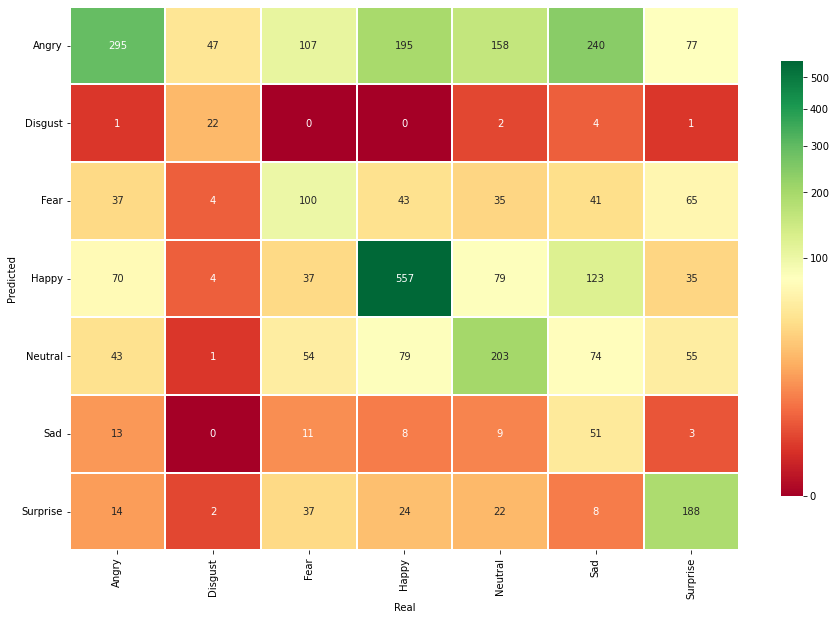

In [31]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad','Surprise']
positions = list(range(len(labels)))
positions = [x+0.5 for x in positions]

print(f'Confusion Matrix')
fig, ax = plt.subplots(figsize=(15, 10))
# plot heatmap
sb.heatmap(confusion_matrix_,
           cmap='RdYlGn',
           annot=True,
           fmt="1d",
           linewidth=0.3,
           cbar_kws={"shrink": .8},
           norm=PowerNorm(vmin=confusion_matrix_.min().min(),
                          vmax=confusion_matrix_.max().max(),
                          gamma=0.35)
          )

plt.xlabel('Real')
ax.set_xticks(positions, labels, rotation = 90)
plt.ylabel('Predicted')
ax.set_yticks(positions, labels, rotation = 0)
plt.show()

In [32]:
model.save("fer_ckplus_DenseNet121_model.h5")
print("Done")

Done
